In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pickle

# **Load Dataset**


In [2]:
df_raw = pd.read_csv('Real_Estate_Sales_2001-2020_GL.csv')
df_raw.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
0,2020348,2020,9/13/2021,Ansonia,230 WAKELEE AVE,150500,325000.0,0.4630,Commercial,Nan,1
1,20002,2020,10/2/2020,Ashford,390 TURNPIKE RD,253000,430000.0,0.5883,Residential,Single Family,0
2,200212,2020,3/9/2021,Avon,5 CHESTNUT DRIVE,130400,179900.0,0.7248,Residential,Condo,1
3,200243,2020,4/13/2021,Avon,111 NORTHINGTON DRIVE,619290,890000.0,0.6958,Residential,Single Family,1
4,200377,2020,7/2/2021,Avon,70 FAR HILLS DRIVE,862330,1447500.0,0.5957,Residential,Single Family,1


### Data is from Kaggel.com [Real Estate Sales 2001-2020](https://www.kaggle.com/datasets/derrekdevon/real-estate-sales-2001-2020)

| Attribute | Description|
| -------- | -------- |
|**Serial Number**| Is just a unique set of digits to identify each transaction.|
|**List year**| This is the year that the particular property was put up for sale.|
|**Date Recorded**| Is the date that the transaction was completed. That is, the year the property was bought.|
|**Town**| The town where this property is located.|
|**Address**| The property's address.|
|**Assessed Value**| How much the property is generally considered to be worth.|
|**Sale Amount**| How much the property was actually sold for.|
|**Sales Ratio**| The ratio measures how close the selling price of the property is to it's assessed value.|
|**Property Type**| What kind of property it is.|
|**Residential Type**| If it is a residential property, what type is it.|
|**Years until sold**| Number of years before the property was finally sold.|

In [3]:
df_raw.dropna(inplace=True)

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     997213 non-null  int64  
 1   List Year         997213 non-null  int64  
 2   Date Recorded     997213 non-null  object 
 3   Town              997213 non-null  object 
 4   Address           997213 non-null  object 
 5   Assessed Value    997213 non-null  int64  
 6   Sale Amount       997213 non-null  float64
 7   Sales Ratio       997213 non-null  float64
 8   Property Type     997213 non-null  object 
 9   Residential Type  997213 non-null  object 
 10  Years until sold  997213 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 83.7+ MB


In [5]:
# convert date recorded values into date type data
df_raw['Date Recorded'] = pd.to_datetime(df_raw['Date Recorded'], format='%m/%d/%Y')

In [6]:
# check for duplicates from all columns
df_raw.duplicated().any()

False

In [7]:
# check for duplicates from selected columns
df_raw.duplicated(subset=['List Year','Address','Date Recorded','Years until sold']).any()

True

In [8]:
# it appears that some of the data are inconsistent because a property had multiple transactions within the same date with different assessed value, sale amount, and sale ratio
df_filtered = df_raw.drop_duplicates(subset=['List Year', 'Town', 'Address','Years until sold']).copy()

In [9]:
df_filtered.replace('Nan', pd.NA, inplace=True)
df_filtered.isna().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                 30
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type       361920
Residential Type    367511
Years until sold         0
dtype: int64

In [10]:
df_filtered.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.617280e+05,961728.000000,961728,9.617280e+05,9.617280e+05,9.617280e+05,961728.000000
mean,4.384073e+05,2010.269882,2011-07-18 10:20:55.939309056,2.722324e+05,3.951550e+05,8.617711e+00,0.748400
min,8.100000e+01,2001.000000,1999-04-05 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,-18.000000
25%,3.049000e+04,2004.000000,2005-08-11 00:00:00,8.820000e+04,1.430000e+05,4.866885e-01,0.000000
50%,7.047400e+04,2010.000000,2011-04-05 00:00:00,1.388100e+05,2.276000e+05,6.226667e-01,1.000000
75%,1.600270e+05,2016.000000,2017-05-01 00:00:00,2.256000e+05,3.650235e+05,7.770370e-01,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,8.815100e+08,5.000000e+09,1.226420e+06,4.000000
std,6.630297e+06,6.230102,NaN,1.613109e+06,5.437774e+06,1.696516e+03,0.436258


# **Data Cleaning for Numeric Data**  


#### From the description about the data above, we can infer that there is inconsistent value in the 'Years until sold' column. It is not possible to have a negative value.

In [11]:
df_filtered.loc[:, 'Years until sold'] = df_filtered['Date Recorded'].dt.year - df_filtered['List Year']

In [12]:
neg_years_until_sold = df_filtered[df_filtered['Years until sold'] < 0].shape[0]
print(f'Total negative values for "Years until sold" column: {neg_years_until_sold}')

Total negative values for "Years until sold" column: 56


In [13]:
# create new dataframe which consist only positive value for the "Years until sold" column
df1 = df_filtered.copy()
df1 = df1[df1['Years until sold'] >= 0]

# to make sure all values in "Years until sold" column are valid, I'm going to recalculate all the values by substracting list year and the year from date recorded
df1['Years until sold'] = df1['Date Recorded'].dt.year - df1['List Year']

In [14]:
df1.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.616720e+05,961672.000000,961672,9.616720e+05,9.616720e+05,9.616720e+05,961672.000000
mean,4.384235e+05,2010.269684,2011-07-18 10:58:07.485961472,2.722355e+05,3.951581e+05,8.618162e+00,0.748671
min,8.100000e+01,2001.000000,2001-10-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,3.049000e+04,2004.000000,2005-08-11 00:00:00,8.820000e+04,1.430000e+05,4.866778e-01,0.000000
50%,7.047300e+04,2010.000000,2011-04-05 00:00:00,1.388100e+05,2.276000e+05,6.226598e-01,1.000000
75%,1.600270e+05,2016.000000,2017-05-01 00:00:00,2.256000e+05,3.650425e+05,7.770369e-01,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,8.815100e+08,5.000000e+09,1.226420e+06,4.000000
std,6.630489e+06,6.230115,NaN,1.613154e+06,5.437931e+06,1.696565e+03,0.433833


#### Based on the newest description above, there are some anomalies in the minimum and maximum value for assessed value, sale amount, and sales ratio  
  
#### Therefore, I want to find total rows that consist of 0 value in at least 1 out of 3 criteria: assessed value, sale amount, and sales ratio

In [15]:
# display all rows with 0 value with these criteria
zero_assessed_value = df1[df1['Assessed Value']==0].shape[0]
zero_sale_amount = df1[df1['Sale Amount']==0].shape[0]
zero_sales_ratio = df1[df1['Sales Ratio']==0].shape[0]

print(f'''
Total data with 0 value of assessed value: {zero_assessed_value}
Total data with 0 value of sale amount: {zero_sale_amount}
Total data with 0 value of sales ratio: {zero_sales_ratio}
''')


Total data with 0 value of assessed value: 6427
Total data with 0 value of sale amount: 1575
Total data with 0 value of sales ratio: 7771



In [16]:
df1[(df1['Assessed Value'] == 0)
           | (df1['Sale Amount'] == 0)
           | (df1['Sales Ratio'] == 0)].head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
75,10323,2001,2002-09-23,Coventry,400 EASTVIEW DR,0,325400.0,0.0,<NA>,<NA>,1
86,10045,2001,2002-01-03,Bethany,9 SIMPSON CT,96590,0.0,0.0,<NA>,<NA>,1
96,12532,2001,2002-08-13,Bolton,45 BEACON CT,0,12350.0,0.0,<NA>,<NA>,1
127,10055,2001,2001-12-04,Stafford,15 JENNIFER LN,0,165155.0,0.0,<NA>,<NA>,0
133,10502,2001,2002-01-15,Stratford,1101 SUCCESS AVE,0,50000.0,0.0,<NA>,<NA>,1


#### From the previous insight, we can conclude that all zero values in the Sales Ratio column happened mostly because there is zero value in the Assessed Value or Sale Amount column

#### After scouring the internet, I got some insight regarding the property price and assessment sales ratio:
1. Based on the property price on [landsearch.com](https://www.landsearch.com/), the cheapest property catalog is over $100. 
2. According to [iaao.org](https://www.iaao.org/media/standards/Standard_on_Ratio_Studies.pdf), property assessment sales ratio is between 90% - 110%

#### Therefore, there are several steps I would do:
1. I will filter out all rows that have assessed value and sale amount less than 100 and assign the dataframe into a new variable
2. I will assume that the assessed value and sale amount have either the same number of digits or a maximum difference of 1 digit between them since I got no extra information on the internet to adjust them better.
3. While adjusting the assessed value or the sale amound digit, I will ensure that the Sales Ratio is between 0.2 and 8

#### Assumptions:
1. Assessed Value and Sale Amount have either the same number of digits or a maximum difference of 1 digit.
2. Sales Ratio below 0.2 is considered invalid because it is way too overprice.
3. Sales Ratio above 8 is considered invalid because it is way too underprice.


In [17]:
# filter out all rows that have assign value and sale amount less than 100 and assign the dataframe into a new variable
df1_assessed_and_sale_above0 = df1.copy()
df1_assessed_and_sale_above0 = df1[(df1['Sale Amount'] > 0) & (df1['Assessed Value'] > 0)].sort_values(by='Assessed Value', ascending=True)

In [18]:
def adjust_assessed_and_sale_digits(data):
    for index,row in data.iterrows():
        assessed_value = row['Assessed Value']
        sale_amount = row['Sale Amount']

        assessed_value_digits = len(str(assessed_value))
        sale_amount_digits = len(str(int(sale_amount)))

        diff = abs(assessed_value_digits - sale_amount_digits)
        # Adjustments
        if diff > 1:
            if assessed_value_digits > sale_amount_digits:
                sale_amount *= (10**diff)
            elif assessed_value_digits < sale_amount_digits:
                assessed_value *= (10**diff)

        # Recalculate sales ratio before making adjustments
        sales_ratio = assessed_value / sale_amount

        # Check and adjust sales ratio if it's not within the desired range
        while sales_ratio < 0.2 or sales_ratio > 8:
            if sales_ratio < 0.2:
                assessed_value *= 10
            elif sales_ratio > 8:
                sale_amount *= 10
            
            # Recalculate sales ratio after adjustments
            sales_ratio = assessed_value / sale_amount
        
        # Update values in the DataFrame using at
        data.at[index, 'Sale Amount'] = sale_amount
        data.at[index, 'Assessed Value'] = int(assessed_value)
        data.at[index, 'Sales Ratio'] = round(sales_ratio, 5)

In [19]:
# Iterate each row to ensure the sales amount digits are equal or equal+1 with the assessed value, and vice versa
adjust_assessed_and_sale_digits(df1_assessed_and_sale_above0)

In [20]:
df1_assessed_and_sale_above0.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.539040e+05,953904.000000,953904,9.539040e+05,9.539040e+05,953904.000000,953904.000000
mean,4.402985e+05,2010.304968,2011-07-31 08:35:16.922457856,3.220957e+05,4.471217e+05,0.760660,0.748762
min,8.100000e+01,2001.000000,2001-10-01 00:00:00,1.400000e+02,1.000000e+02,0.200000,0.000000
25%,3.050200e+04,2004.000000,2005-08-19 00:00:00,9.327000e+04,1.450000e+05,0.503140,0.000000
50%,7.060200e+04,2010.000000,2011-05-06 00:00:00,1.443400e+05,2.300000e+05,0.634790,1.000000
75%,1.600420e+05,2016.000000,2017-05-09 00:00:00,2.368100e+05,3.700000e+05,0.796800,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,2.238530e+09,5.000000e+09,8.000000,4.000000
std,6.651574e+06,6.227816,NaN,3.397089e+06,5.686204e+06,0.581548,0.433781


#### For the next step, I will handle the rows that have value equal to 0 in either the Assessed Value or Sale Amount column, but exceeds 0 in one of them.

In [21]:
# get all rows that have value equal to 0 in either the Assessed Value or Sale Amount column, but exceeds 0 in one of them.
df1_assessed_or_sale_eq0 = df1.copy()
df1_assessed_or_sale_eq0 = df1[(((df1['Sale Amount'] == 0) & (df1['Assessed Value'] > 0))) 
                               | (((df1['Sale Amount'] > 0) & (df1['Assessed Value'] == 0)))]
df1_assessed_or_sale_eq0.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
75,10323,2001,2002-09-23,Coventry,400 EASTVIEW DR,0,325400.0,0.0,<NA>,<NA>,1
86,10045,2001,2002-01-03,Bethany,9 SIMPSON CT,96590,0.0,0.0,<NA>,<NA>,1
96,12532,2001,2002-08-13,Bolton,45 BEACON CT,0,12350.0,0.0,<NA>,<NA>,1
127,10055,2001,2001-12-04,Stafford,15 JENNIFER LN,0,165155.0,0.0,<NA>,<NA>,0
133,10502,2001,2002-01-15,Stratford,1101 SUCCESS AVE,0,50000.0,0.0,<NA>,<NA>,1


In [22]:
# margin of error for adjusting the sales ratio
z = 1.96 # confidence level 95%
std = df1_assessed_and_sale_above0['Sales Ratio'].std()
n = df1_assessed_or_sale_eq0.shape[0]

# margin of error formula: z * (standard deviation / sqrt(sample size))
moe = z * (std/(n**(1/2)))
moe

0.013131942941407175

In [23]:
# adjust the sales ratio 
for index,row in df1_assessed_or_sale_eq0.iterrows():
    # variable initiation
    assessed_value = row['Assessed Value']
    sale_amount = row['Sale Amount']
    sales_ratio = round(random.uniform(0.9-moe,1.1+moe),5)
    
    # replace 0 value in the Assessed Value and/or Sale Amount column
    if assessed_value < 100:
        assessed_value = sales_ratio * sale_amount
    elif sale_amount < 100:
        sale_amount = assessed_value / sales_ratio

    df1_assessed_or_sale_eq0.loc[index, 'Sale Amount'] = sale_amount
    df1_assessed_or_sale_eq0.loc[index, 'Assessed Value'] = int(assessed_value)
    df1_assessed_or_sale_eq0.loc[index, 'Sales Ratio'] = sales_ratio

To finish the numeric data cleaning, I will concatenat df1_assessed_or_sale_eq0 and df1_assessed_and_sale_above0

In [24]:
df1_assessed_and_sale_above0_done = pd.concat([df1_assessed_and_sale_above0,df1_assessed_or_sale_eq0])

In [25]:
df1_assessed_and_sale_above0_done.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.614380e+05,961438.000000,961438,9.614380e+05,9.614380e+05,961438.000000,961438.000000
mean,4.385210e+05,2010.271386,2011-07-19 01:47:30.447767040,3.221012e+05,4.461508e+05,0.762536,0.748659
min,8.100000e+01,2001.000000,2001-10-01 00:00:00,0.000000e+00,0.000000e+00,0.200000,0.000000
25%,3.049000e+04,2004.000000,2005-08-12 00:00:00,9.319000e+04,1.450000e+05,0.504182,0.000000
50%,7.047850e+04,2010.000000,2011-04-06 00:00:00,1.444800e+05,2.300000e+05,0.636790,1.000000
75%,1.600280e+05,2016.000000,2017-05-01 00:00:00,2.374000e+05,3.700000e+05,0.803080,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,2.238530e+09,5.000000e+09,8.000000,4.000000
std,6.631293e+06,6.229872,NaN,3.385463e+06,5.664976e+06,0.579679,0.433840


#### Next, I will do feature engineering to replace 0 values in both Assessed Value and Sale Amount columns

In [26]:
df1_assessed_and_sale_eq0 = df1[(df1['Assessed Value']==0) & (df1['Sale Amount']==0)].copy()
df1_assessed_and_sale_eq0.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
41139,39004,2003,2003-10-21,Easton,15 FENSKY RD,0,0.0,0.0,<NA>,<NA>,0
65969,30102,2003,2004-06-09,Thomaston,76 LITCHFIELD ST,0,0.0,0.0,<NA>,<NA>,1
66842,30130,2003,2004-06-24,Thomaston,26-28 GROVE ST,0,0.0,0.0,<NA>,<NA>,1
66848,39999,2003,2004-02-02,West Haven,<NA>,0,0.0,0.0,<NA>,<NA>,1
66878,49888,2004,2005-07-12,Bridgeport,1650 RESERVOUIR,0,0.0,0.0,<NA>,<NA>,1


In [27]:
def random_sample_impute(data, feature):
    random_sample = df1_assessed_and_sale_above0_done[feature].sample(data.shape[0], random_state=0)
    random_sample.index = data[feature].index
    data.loc[:, feature] = random_sample

In [28]:
# impute 0 values for the Assessed Value column
random_sample_impute(df1_assessed_and_sale_eq0, 'Assessed Value')

# impute 0 values for the Sale Amount column
random_sample_impute(df1_assessed_and_sale_eq0, 'Sale Amount')

In [29]:
# Iterate each row to ensure the sales amount digits are equal or equal+1 with the assessed value, and vice versa
adjust_assessed_and_sale_digits(df1_assessed_and_sale_eq0)

In [30]:
df1_assessed_and_sale_eq0.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
41139,39004,2003,2003-10-21,Easton,15 FENSKY RD,235000,450000.0,0.52222,<NA>,<NA>,0
65969,30102,2003,2004-06-09,Thomaston,76 LITCHFIELD ST,169890,265000.0,0.64109,<NA>,<NA>,1
66842,30130,2003,2004-06-24,Thomaston,26-28 GROVE ST,99490,150000.0,0.66327,<NA>,<NA>,1
66848,39999,2003,2004-02-02,West Haven,<NA>,292700,292500.0,1.00068,<NA>,<NA>,1
66878,49888,2004,2005-07-12,Bridgeport,1650 RESERVOUIR,100080,180000.0,0.55600,<NA>,<NA>,1


In [31]:
df1_numeric_clean = pd.concat([df1_assessed_and_sale_above0_done,df1_assessed_and_sale_eq0])

In [32]:
df1_numeric_clean.describe()

,Serial Number,List Year,Date Recorded,Assessed Value,Sale Amount,Sales Ratio,Years until sold
count,9.616720e+05,961672.000000,961672,9.616720e+05,9.616720e+05,961672.000000,961672.000000
mean,4.384235e+05,2010.269684,2011-07-18 10:58:07.485961984,3.220778e+05,4.461280e+05,0.762527,0.748671
min,8.100000e+01,2001.000000,2001-10-01 00:00:00,0.000000e+00,0.000000e+00,0.200000,0.000000
25%,3.049000e+04,2004.000000,2005-08-11 00:00:00,9.319000e+04,1.450000e+05,0.504180,0.000000
50%,7.047300e+04,2010.000000,2011-04-05 00:00:00,1.444800e+05,2.300000e+05,0.636790,1.000000
75%,1.600270e+05,2016.000000,2017-05-01 00:00:00,2.374000e+05,3.700000e+05,0.803072,1.000000
max,2.000500e+09,2020.000000,2021-09-30 00:00:00,2.238530e+09,5.000000e+09,8.000000,4.000000
std,6.630489e+06,6.230115,NaN,3.385055e+06,5.664290e+06,0.579661,0.433833



# **Data Cleaning for String Data**

In [33]:
df2 = df1_numeric_clean.copy()

In [34]:
df2.isna().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                 30
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type       361915
Residential Type    367506
Years until sold         0
dtype: int64

In [35]:
df2['Property Type'].value_counts()

Property Type
Single Family     391276
Condo             103444
Residential        59694
Two Family         25521
Three Family       12129
Vacant Land         2944
Four Family         2102
Commercial          1938
Apartments           479
Industrial           226
Public Utility         4
Name: count, dtype: int64

In [36]:
df2['Residential Type'].value_counts()

Residential Type
Single Family    433885
Condo            115658
Two Family        28665
Three Family      13596
Four Family        2362
Name: count, dtype: int64

#### Based on the insight about property types and the research I did on study.com, I've decided to devide the property types into 5 groups:
1. Residential (Singe Family, Multi-Family, Condo, Apartment)
2. Industrial
3. Commercial
4. Public Utility
5. Vacant Land

In [37]:
# Update the residential type based on conditions
conditions = df2['Property Type'].isin(['Single Family', 'Two Family', 'Three Family', 'Four Family', 'Condo', 'Apartments'])
df2.loc[conditions, 'Residential Type'] = df2.loc[conditions, 'Property Type']


df2['Residential Type'].value_counts()

Residential Type
Single Family    433885
Condo            115658
Two Family        28665
Three Family      13596
Four Family        2362
Apartments          479
Name: count, dtype: int64

In [38]:
# Update the property type based on conditions
conditions = df2['Property Type'].isin(['Single Family', 'Two Family', 'Three Family', 'Four Family', 'Condo', 'Apartments'])
df2.loc[conditions, 'Property Type'] = 'Residential'


df2['Property Type'].value_counts()

Property Type
Residential       594645
Vacant Land         2944
Commercial          1938
Industrial           226
Public Utility         4
Name: count, dtype: int64

In [39]:
df2.loc[df2['Address']=='parking space only','Property Type']='Public Utility'

#### To determine the property type and the residential type, I'm going to use machine learning to classify the data

In [40]:
df2_ml = df2[['Assessed Value', 'Sale Amount', 'Sales Ratio', 'Years until sold', 'Property Type', 'Residential Type']].copy()
df2_ml.head()

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type,Residential Type
58884,1000,3500.0,0.28571,1,Vacant Land,<NA>
816649,1000000,4150000.0,0.24096,1,<NA>,<NA>
678302,100000,80830.0,1.23716,1,Residential,Single Family
719532,1000,4947.0,0.20214,0,<NA>,<NA>
470663,1000,4000.0,0.25000,1,<NA>,<NA>


In [41]:
# filter the dataset from Nan values
df2_ml_not_nan_pt = df2_ml[df2_ml['Property Type'].notna()].drop('Residential Type', axis=1)
df2_ml_not_nan_pt

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type
58884,1000,3500.0,0.28571,1,Vacant Land
678302,100000,80830.0,1.23716,1,Residential
681182,10000,41680.0,0.23992,1,Residential
748599,5000,3125.0,1.60000,1,Residential
17155,500000,143995.0,3.47234,1,Residential
...,...,...,...,...,...
992641,328671,360730.0,0.91113,1,Residential
994922,387327,418905.0,0.92462,1,Residential
996063,221672,230450.0,0.96191,1,Residential
996597,444390,482850.0,0.92035,1,Residential


#### 1. Prediction for Property Type

In [42]:
def scale_dataset(data, target_column, oversample=False):
    X = data[data.columns[:-1]].values
    y = data[target_column].values

    # scale the feature data to make the value range more reasonable and help the computer learn more efficient
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # oversampling data to make the data distribution more balance
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)
    
    
    data = np.hstack([X,y.reshape(-1,1)])

    return data,  X, y

In [43]:
# split the dataset
pt_train, pt_test = train_test_split(df2_ml_not_nan_pt, test_size=0.6, random_state= 42, shuffle= True)

In [44]:
# scale and oversample train and test dataset
pt_train, pt_X_train, pt_y_train = scale_dataset(pt_train, 'Property Type', oversample=True)
pt_test, pt_X_test, pt_y_test = scale_dataset(pt_test, 'Property Type', oversample=False)

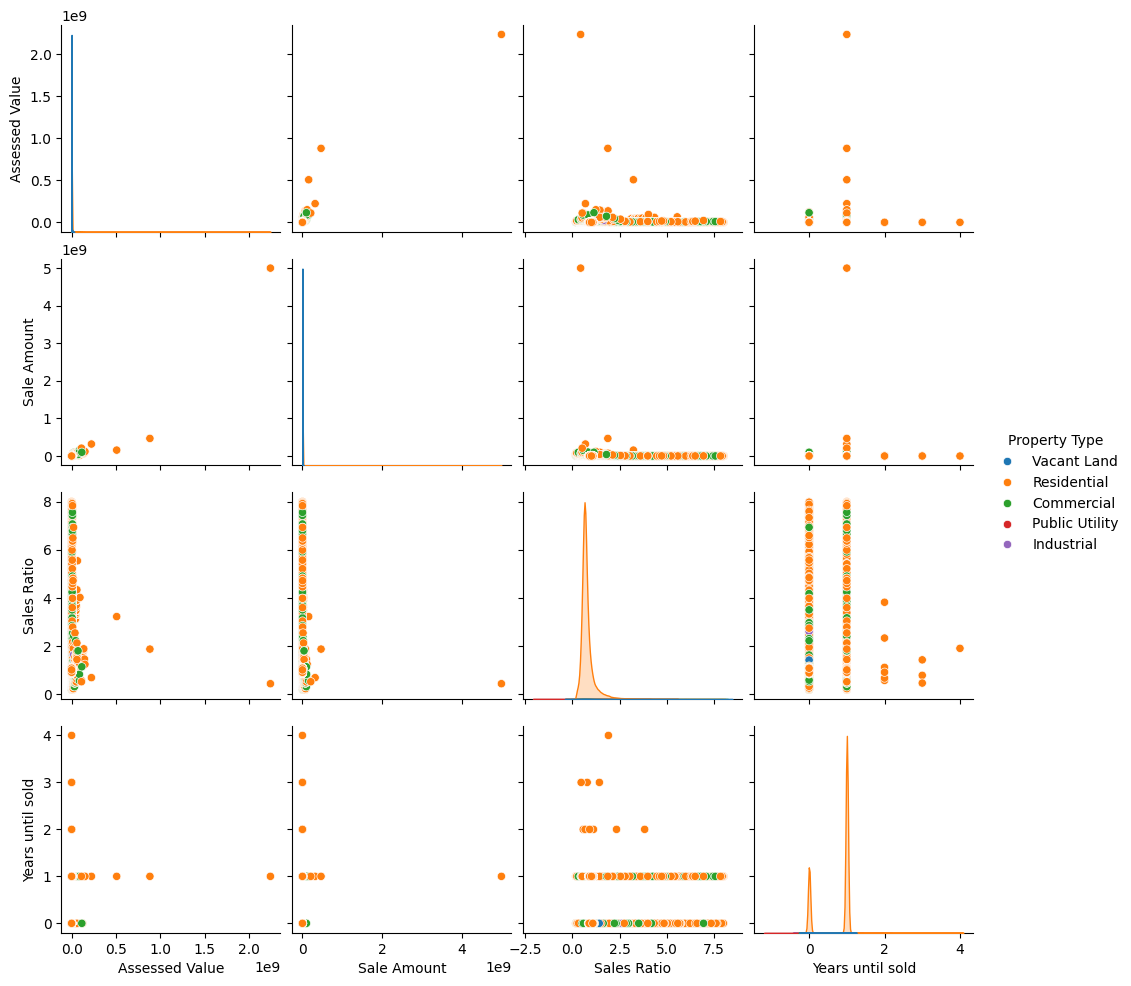

In [45]:
# pairplot for property type
sns.pairplot(df2_ml_not_nan_pt, hue= 'Property Type')
plt.show()

Since the data points that we have are overlapping one another, the kNN model would perform great in this scenario because the kNN model is based on Euclidean Distance, which the model will predict the class of a point based on its nearby points. It's good for situations where different classes mix in the data.

In [46]:
knn = KNeighborsClassifier()
knn.fit(pt_X_train, pt_y_train) # train knn

# make prediction
pt_y_pred = knn.predict(pt_X_test)

# test set evaluation
report = classification_report(pt_y_test, pt_y_pred)
knn_accuracy_score = accuracy_score(pt_y_test, pt_y_pred)
knn_precision_score = precision_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_recall_score = recall_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_f1_score = f1_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average

print('-'*35)
print(f'Accuracy Score: {round(knn_accuracy_score,5)}')
print(f'Precision Score: {round(knn_precision_score,5)}')
print(f'Recall Score: {round(knn_recall_score,5)}')
print(f'F1 Score: {round(knn_f1_score,5)}')
print(f'Labels with no predicted samples: {set(np.unique(pt_y_test)) - set(np.unique(pt_y_pred))}')
print('-'*35)

C:\Users\fredl\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fredl\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fredl\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

-----------------------------------
Accuracy Score: 0.97335
Precision Score: 0.98339
Recall Score: 0.97335
F1 Score: 0.97832
Labels with no predicted samples: {'Public Utility'}
-----------------------------------


kNN hyperparameter tuning for property type prediction model

In [47]:
# define the parameters
knn_params = {
    'n_neighbors': range(1,10,2)
}

# grid search
cv = StratifiedKFold(n_splits= 10)
grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, cv=cv, scoring='accuracy', verbose=2)
grid_result = grid_search.fit(pt_X_train, pt_y_train)

# final model and make prediction
final_knn = KNeighborsClassifier(**grid_result.best_params_)
final_knn.fit(pt_X_train, pt_y_train)
pt_y_pred = final_knn.predict(pt_X_test)

# test set evaluation
knn_accuracy_score = accuracy_score(pt_y_test, pt_y_pred)
knn_precision_score = precision_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_recall_score = recall_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average
knn_f1_score = f1_score(pt_y_test, pt_y_pred, average='weighted', zero_division=0)  # Choose the appropriate average

print('-'*35)
print(f'Accuracy Score: {round(knn_accuracy_score,5)}')
print(f'Precision Score: {round(knn_precision_score,5)}')
print(f'Recall Score: {round(knn_recall_score,5)}')
print(f'F1 Score: {round(knn_f1_score,5)}')
print(f'Labels with no predicted samples: {set(np.unique(pt_y_test)) - set(np.unique(pt_y_pred))}')
print(f'Best parameters: {grid_result.best_params_}')
print('-'*35)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END ......................................n_neighbors=1; total time=  39.4s
[CV] END ......................................n_neighbors=1; total time=  39.8s
[CV] END ......................................n_neighbors=1; total time=  40.3s
[CV] END ......................................n_neighbors=1; total time=  39.0s
[CV] END ......................................n_neighbors=1; total time=  39.0s
[CV] END ......................................n_neighbors=1; total time=  38.7s
[CV] END ......................................n_neighbors=1; total time=  38.8s
[CV] END ......................................n_neighbors=1; total time=  39.3s
[CV] END ......................................n_neighbors=1; total time=  38.8s
[CV] END ......................................n_neighbors=1; total time=  38.7s
[CV] END ......................................n_neighbors=3; total time=  39.0s
[CV] END ......................................n

In [48]:
# save knn model
with open('final_knn','wb') as f:
    pickle.dump(final_knn, f)

Predict the property type of a feature data that have "Nan" value in the Property Type column

In [49]:
# get all row consisting of "Nan" in the Property Type column
df2_nan_pt_predict = df2_ml[df2_ml['Property Type'].isna()].drop('Residential Type', axis=1).copy()
df2_nan_pt_predict.head()

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type
816649,1000000,4150000.0,0.24096,1,<NA>
719532,1000,4947.0,0.20214,0,<NA>
470663,1000,4000.0,0.25000,1,<NA>
321685,100000,308700.0,0.32394,1,<NA>
698042,10000,11192.0,0.89350,0,<NA>


In [50]:
# load knn model
with open('final_knn', 'rb') as f:
    knn_property_type = pickle.load(f)

In [51]:
# predict the data using the final_knn model
nan_pt_predict = knn_property_type.predict(df2_nan_pt_predict[df2_nan_pt_predict.columns[:-1]].values)
nan_pt_predict

array(['Residential', 'Residential', 'Residential', ..., 'Residential',
       'Residential', 'Residential'], dtype=object)

In [52]:
# update the all the Nan(s) in the Property Type column with the predicted value
df2_nan_pt_predict['Property Type'] = nan_pt_predict.reshape(-1,)

# combine predicted property type dataframe with the non_nan property type dataframe
df2_pt_predict_done = pd.concat([df2_nan_pt_predict, df2_ml_not_nan_pt])

# update the dataframe that we've prepared to perform machine learning in the beginning so that we can use for the next prediction
df2_ml[df2_ml.columns[:-1]] = df2_pt_predict_done.reindex(df2_ml.index) # use reindex to match indices of df2_ml


In [53]:
df2_ml.isna().sum()

Assessed Value           0
Sale Amount              0
Sales Ratio              0
Years until sold         0
Property Type            0
Residential Type    367027
dtype: int64

#### 2. Prediction for the residential type

In [54]:
df2_ml_rt = df2_ml[df2_ml['Property Type'] == 'Residential'].copy()

In [55]:
df2_ml_rt.head()

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Property Type,Residential Type
816649,1000000,4150000.0,0.24096,1,Residential,<NA>
678302,100000,80830.0,1.23716,1,Residential,Single Family
719532,1000,4947.0,0.20214,0,Residential,<NA>
470663,1000,4000.0,0.25000,1,Residential,<NA>
681182,10000,41680.0,0.23992,1,Residential,Single Family


In [56]:
df2_ml_rt['Residential Type'].value_counts()

Residential Type
Single Family    433885
Condo            115658
Two Family        28665
Three Family      13596
Four Family        2362
Apartments          479
Name: count, dtype: int64

In [57]:
df2_ml_non_nan_rt = df2_ml_rt[df2_ml_rt['Residential Type'].notna()].drop('Property Type', axis= 1).copy()
df2_ml_non_nan_rt

,Assessed Value,Sale Amount,Sales Ratio,Years until sold,Residential Type
678302,100000,80830.0,1.23716,1,Single Family
681182,10000,41680.0,0.23992,1,Single Family
748599,5000,3125.0,1.60000,1,Single Family
17155,500000,143995.0,3.47234,1,Single Family
721118,70000,60000.0,1.16667,1,Condo
...,...,...,...,...,...
992641,328671,360730.0,0.91113,1,Condo
994922,387327,418905.0,0.92462,1,Condo
996063,221672,230450.0,0.96191,1,Single Family
996597,444390,482850.0,0.92035,1,Condo


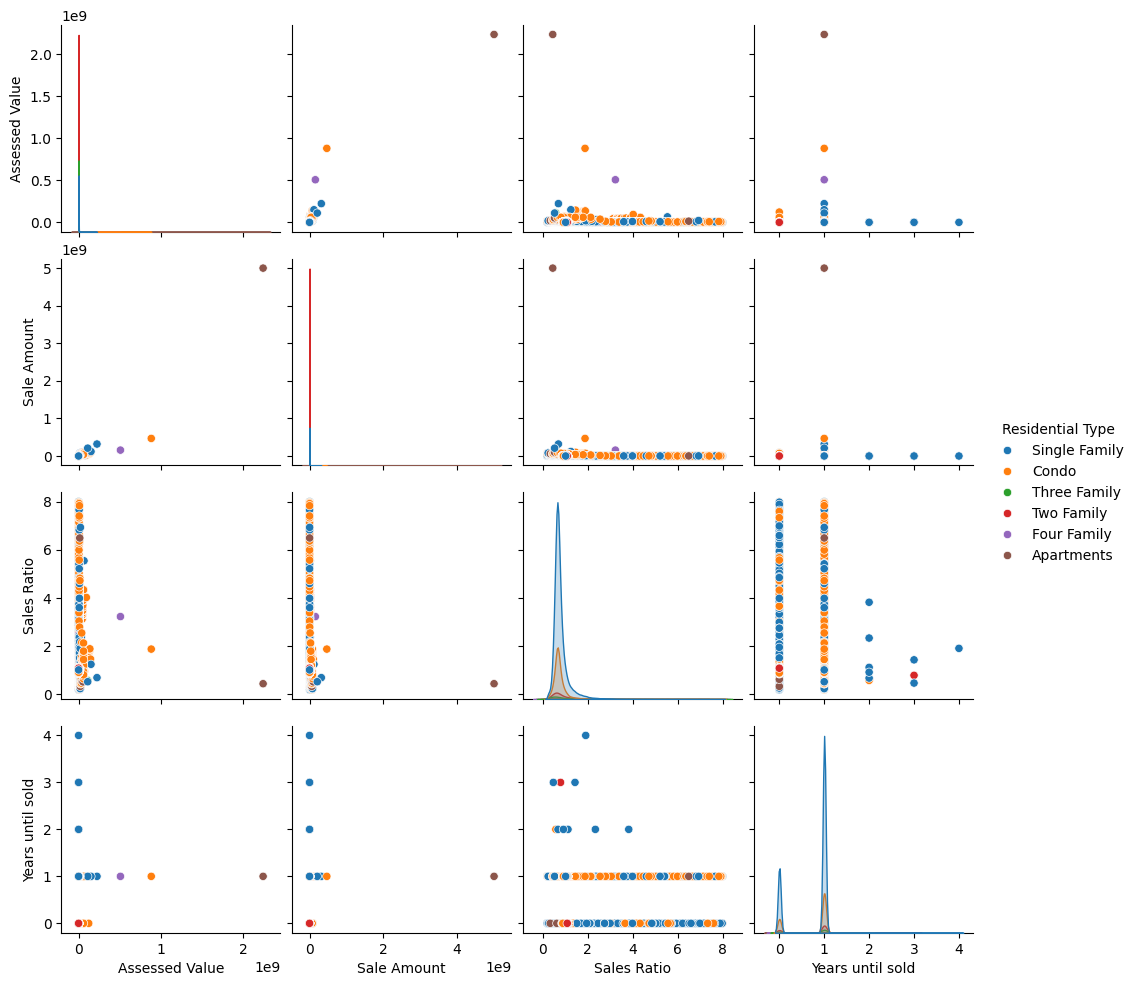

In [58]:
# pairplot for residential type
sns.pairplot(df2_ml_non_nan_rt, hue= 'Residential Type')
plt.show()

In [59]:
rt_train, rt_test = train_test_split(df2_ml_non_nan_rt, test_size= 0.6, random_state= 42, shuffle= True)

In [60]:
rt_train, rt_X_train, rt_y_train = scale_dataset(rt_train, 'Residential Type', oversample= True)
rt_test, rt_X_test, rt_y_test = scale_dataset(rt_test, 'Residential Type', oversample= False)

In [61]:
knn_residential = KNeighborsClassifier()

knn_residential.fit(rt_X_train, rt_y_train)
rt_y_pred = knn_residential.predict(rt_X_test)

# result
accuracy = accuracy_score(rt_y_test, rt_y_pred)
precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')

print('-'*35)
print(f'Accuracy = {accuracy}')
print(f'Precision Score = {precision}')
print(f'Recall Score = {recall}')
print(f'F1-score = {f1}')
print('-'*35)

-----------------------------------
Accuracy = 0.4998696701393268
Precision Score = 0.5880438574046686
Recall Score = 0.4998696701393268
F1-score = 0.5351998355641144
-----------------------------------


In [62]:
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

for i in range (len(list(models))):
    model = list(models.values())[i]

    model.fit(rt_X_train, rt_y_train)
    rt_y_pred = model.predict(rt_X_test)

    # result
    accuracy = accuracy_score(rt_y_test, rt_y_pred)
    precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
    recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
    f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')


    print('-'*35)
    print(list(models.keys())[i])
    print('-'*35)
    print(f'Accuracy = {accuracy}')
    print(f'Precision Score = {precision}')
    print(f'Recall Score = {recall}')
    print(f'F1-score = {f1}')
    print('-'*35)
    print()

-----------------------------------
Naive Bayes
-----------------------------------
Accuracy = 0.038451513087640526
Precision Score = 0.680914598310634
Recall Score = 0.038451513087640526
F1-score = 0.03365467141592554
-----------------------------------

-----------------------------------
Decision Tree
-----------------------------------
Accuracy = 0.5941135747658968
Precision Score = 0.5854686362484639
Recall Score = 0.5941135747658968
F1-score = 0.5877429444351424
-----------------------------------



C:\Users\fredl\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-----------------------------------
Random Forest
-----------------------------------
Accuracy = 0.7233783742120649
Precision Score = 0.5740623969006695
Recall Score = 0.7233783742120649
F1-score = 0.617939368195329
-----------------------------------



None of the machine learning models are performing well enough. Therfore, I need to do other approaches.

#### 2a. Replace some NaN values in the Residential Type column with residential type property in the same street

In [63]:
df2_ml = df2_ml[['Assessed Value', 'Sale Amount', 'Sales Ratio', 'Property Type', 'Residential Type', 'Years until sold']]
df2_ml.head()

,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
58884,1000,3500.0,0.28571,Vacant Land,<NA>,1
816649,1000000,4150000.0,0.24096,Residential,<NA>,1
678302,100000,80830.0,1.23716,Residential,Single Family,1
719532,1000,4947.0,0.20214,Residential,<NA>,0
470663,1000,4000.0,0.25000,Residential,<NA>,1


In [64]:
# combine the df2_ml with df1_numeric done
df2_numeric_and_property_done =  df1_numeric_clean.copy()
df2_numeric_and_property_done.iloc[:, 5:] = df2_ml.reindex(df2_numeric_and_property_done.index)
df2_numeric_and_property_done.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
58884,20323,2020,2021-04-16,Waterford,ROBERTS COURT,1000,3500.0,0.28571,Vacant Land,<NA>,1
816649,160511,2016,2017-03-31,Hamden,42 WARNER ST,1000000,4150000.0,0.24096,Residential,<NA>,1
678302,130111,2013,2014-09-04,Westbrook,5 PINE CONE DR,100000,80830.0,1.23716,Residential,Single Family,1
719532,140063,2014,2014-11-17,East Lyme,SO TRAIL,1000,4947.0,0.20214,Residential,<NA>,0
470663,70022,2007,2008-03-12,Sharon,ROUTE 343,1000,4000.0,0.25000,Residential,<NA>,1


In [65]:
# function to clean the address
def clean_address(address):
    words = address.split()  # split the address into words
    cleaned_words = []
    for word in words:
        cleaned_word = ''.join(e for e in word if e.isalpha())  # remove special characters and numbers
        if len(cleaned_word) >= 3:  # consider a word has minimum of 3 letters
            cleaned_words.append(cleaned_word)
    return (' '.join(cleaned_words)).lstrip()  # join the cleaned words back into a string

In [66]:
# Apply the function to create a new column
df2_numeric_and_property_done['Clean Address'] = df2_numeric_and_property_done['Address'].apply(lambda x: clean_address(x) if pd.notna(x) else x)
df2_numeric_and_property_done.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold,Clean Address
58884,20323,2020,2021-04-16,Waterford,ROBERTS COURT,1000,3500.0,0.28571,Vacant Land,<NA>,1,ROBERTS COURT
816649,160511,2016,2017-03-31,Hamden,42 WARNER ST,1000000,4150000.0,0.24096,Residential,<NA>,1,WARNER
678302,130111,2013,2014-09-04,Westbrook,5 PINE CONE DR,100000,80830.0,1.23716,Residential,Single Family,1,PINE CONE
719532,140063,2014,2014-11-17,East Lyme,SO TRAIL,1000,4947.0,0.20214,Residential,<NA>,0,TRAIL
470663,70022,2007,2008-03-12,Sharon,ROUTE 343,1000,4000.0,0.25000,Residential,<NA>,1,ROUTE


In [67]:
# select rows where 'Property Type' is 'Residential' and 'Residential Type' is not 'NaN'
filtered_df = df2_numeric_and_property_done[(df2_numeric_and_property_done['Property Type'] == 'Residential') & (df2_numeric_and_property_done['Residential Type'].notna())].sort_values(by=['Clean Address', 'Residential Type'])

# create new dataframe 
clean_address_residential = filtered_df[['Clean Address', 'Residential Type']]

# find the number of unique resident type value for each clean address
unique_addresses = clean_address_residential.groupby('Clean Address')['Residential Type'].nunique().reset_index()

# filter the grouped addresses to include only those with a single 'Residential Type'
single_residential_address = unique_addresses[unique_addresses['Residential Type'] == 1]['Clean Address'].values

# filter the unique addresses DataFrame to include only the clean addresses with a single 'Residential Type'
filtered_unique_addresses = clean_address_residential[clean_address_residential['Clean Address'].isin(single_residential_address)].drop_duplicates()

# convert the filtered unique addresses DataFrame to a dictionary
unique_addresses_dict = filtered_unique_addresses.set_index('Clean Address')['Residential Type'].to_dict()

In [68]:
unique_addresses_dict

{'AARON': 'Single Family',
 'AARON SAMUELS BLVD': 'Two Family',
 'AARONS': 'Single Family',
 'AARONS WAY': 'Single Family',
 'ABAR': 'Single Family',
 'ABAR LANE': 'Single Family',
 'ABBE EXT': 'Single Family',
 'ABBE LANE': 'Single Family',
 'ABBE ROAD': 'Single Family',
 'ABBEWOOD': 'Condo',
 'ABBEWOOD DRIVE': 'Condo',
 'ABBEY ROAD': 'Single Family',
 'ABBIE': 'Single Family',
 'ABBOSTFORD AVE': 'Single Family',
 'ABBOT': 'Condo',
 'ABBOTS': 'Single Family',
 'ABBOTSFORD': 'Condo',
 'ABBOTSS HILL ROAD': 'Single Family',
 'ABBOTT AVE': 'Single Family',
 'ABBOTT AVENUE': 'Single Family',
 'ABBOTT FARMS': 'Single Family',
 'ABBOTT UNIT': 'Condo',
 'ABBOTTS': 'Single Family',
 'ABBOTTS HILL ROAD': 'Single Family',
 'ABBOTTS LANE': 'Single Family',
 'ABBOTTSFORD': 'Condo',
 'ABBY': 'Single Family',
 'ABBY LANE': 'Single Family',
 'ABBY PARK': 'Condo',
 'ABBY ROAD': 'Single Family',
 'ABC FAIRFIELD BEACH': 'Condo',
 'ABDG APT COURT': 'Single Family',
 'ABEL XING': 'Condo',
 'ABERDEEN COURT

In [69]:
# fill some NaN values in the Residential Type column if the corresponding Clean Address is available in the unique_addresses_dict
# df2_numeric_and_property_done['Residential Type'] = df2_numeric_and_property_done.apply(lambda x: x['Residential Type'] 
#                                                                                              if x['Property Type'] != 'Residential' 
#                                                                                              else (x['Residential Type']
#                                                                                                    if pd.notna(x['Residential Type'])
#                                                                                                    else x['Residential Type'].fill(x['Clean Address'].map(unique_addresses_dict))), 
#                                                                                              axis=1)

df2_numeric_and_property_done['Residential Type'] = df2_numeric_and_property_done.apply(lambda x: x['Residential Type'] 
                                                                                             if x['Property Type'] != 'Residential' 
                                                                                             else (x['Residential Type']
                                                                                                   if pd.notna(x['Residential Type'])
                                                                                                   else unique_addresses_dict.get(x['Clean Address'], np.nan)), 
                                                                                             axis=1)


In [70]:
df2_numeric_and_property_done[(df2_numeric_and_property_done['Property Type']!='Residential')
                              & (df2_numeric_and_property_done['Residential Type'].notna())]

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold,Clean Address


In [71]:
df2_numeric_and_property_done.isna().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                 30
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type            0
Residential Type    278409
Years until sold         0
Clean Address           30
dtype: int64

#### 2b. Label encoded Town feature

In [72]:
from sklearn.preprocessing import LabelEncoder

In [73]:
label_encoder = LabelEncoder()

In [74]:
df2_label_encoder = df2_numeric_and_property_done.copy()

In [75]:
df2_label_encoder['Town Encoded'] = label_encoder.fit_transform(df2_label_encoder['Town'])

In [76]:
df2_label_encoder.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold,Clean Address,Town Encoded
58884,20323,2020,2021-04-16,Waterford,ROBERTS COURT,1000,3500.0,0.28571,Vacant Land,<NA>,1,ROBERTS COURT,152
816649,160511,2016,2017-03-31,Hamden,42 WARNER ST,1000000,4150000.0,0.24096,Residential,NaN,1,WARNER,62
678302,130111,2013,2014-09-04,Westbrook,5 PINE CONE DR,100000,80830.0,1.23716,Residential,Single Family,1,PINE CONE,156
719532,140063,2014,2014-11-17,East Lyme,SO TRAIL,1000,4947.0,0.20214,Residential,NaN,0,TRAIL,44
470663,70022,2007,2008-03-12,Sharon,ROUTE 343,1000,4000.0,0.25000,Residential,NaN,1,ROUTE,125


In [77]:
df2_ml_rt_le = df2_label_encoder[['Town Encoded','Years until sold', 'Assessed Value', 'Sale Amount', 'Sales Ratio', 'Property Type', 'Residential Type']]
df2_ml_rt_le.describe()

,Town Encoded,Years until sold,Assessed Value,Sale Amount,Sales Ratio
count,961672.000000,961672.000000,9.616720e+05,9.616720e+05,961672.000000
mean,89.210533,0.748671,3.220778e+05,4.461280e+05,0.762527
std,47.424723,0.433833,3.385055e+06,5.664290e+06,0.579661
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.200000
25%,51.000000,0.000000,9.319000e+04,1.450000e+05,0.504180
50%,89.000000,1.000000,1.444800e+05,2.300000e+05,0.636790
75%,135.000000,1.000000,2.374000e+05,3.700000e+05,0.803072
max,169.000000,4.000000,2.238530e+09,5.000000e+09,8.000000


In [78]:
df2_ml_non_nan_rt_le = df2_ml_rt_le[(df2_ml_rt_le['Residential Type'].notna())
                               & (df2_ml_rt_le['Property Type']=='Residential')].drop('Property Type', axis= 1).copy()
df2_ml_non_nan_rt_le  

,Town Encoded,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Residential Type
678302,156,1,100000,80830.0,1.23716,Single Family
681182,156,1,10000,41680.0,0.23992,Single Family
712586,44,0,1000,4617.0,0.21659,Single Family
379808,52,0,200000,369318.0,0.54154,Condo
267595,101,1,300000,425000.0,0.70588,Single Family
...,...,...,...,...,...,...
307257,85,1,463840,580000.0,0.79972,Single Family
320979,162,1,40314,97000.0,0.41561,Single Family
323184,103,0,283220,520000.0,0.54465,Condo
344353,158,0,124110,185000.0,0.67086,Single Family


In [79]:
rt_train, rt_test = train_test_split(df2_ml_non_nan_rt_le, test_size= 0.6, random_state= 42, shuffle= True)

In [80]:
rt_train, rt_X_train, rt_y_train = scale_dataset(rt_train, 'Residential Type', oversample= True)
rt_test, rt_X_test, rt_y_test = scale_dataset(rt_test, 'Residential Type', oversample= False)

In [81]:
random_forest = RandomForestClassifier()

random_forest.fit(rt_X_train, rt_y_train)
rt_y_pred = random_forest.predict(rt_X_test)

# result
accuracy = accuracy_score(rt_y_test, rt_y_pred)
precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')

print('-'*35)
print(f'Accuracy = {accuracy}')
print(f'Precision Score = {precision}')
print(f'Recall Score = {recall}')
print(f'F1-score = {f1}')
print('-'*35)

-----------------------------------
Accuracy = 0.7493426155850111
Precision Score = 0.6689993011315392
Recall Score = 0.7493426155850111
F1-score = 0.6658994695239656
-----------------------------------


#### 2c. Apply One-Hot-Encoding for Top 10 towns

In [82]:
df2_ml_rt_ohe = df2_numeric_and_property_done[['Town','Years until sold', 'Assessed Value', 'Sale Amount', 'Sales Ratio', 'Property Type', 'Residential Type']]
df2_ml_rt_ohe.head()

,Town,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
58884,Waterford,1,1000,3500.0,0.28571,Vacant Land,<NA>
816649,Hamden,1,1000000,4150000.0,0.24096,Residential,NaN
678302,Westbrook,1,100000,80830.0,1.23716,Residential,Single Family
719532,East Lyme,0,1000,4947.0,0.20214,Residential,NaN
470663,Sharon,1,1000,4000.0,0.25000,Residential,NaN


In [83]:
top10_towns = np.array(df2_ml_rt_ohe[(df2_ml_rt_ohe['Property Type']=='Residential')
                              & (df2_ml_rt_ohe['Residential Type'].notna())]['Town'].value_counts().head(10).index)
top10_towns

array(['Stamford', 'Bridgeport', 'Waterbury', 'Norwalk', 'West Hartford',
       'Danbury', 'Greenwich', 'Fairfield', 'Milford', 'New Haven'],
      dtype=object)

In [84]:
for town in top10_towns:
    df2_ml_rt_ohe[town] = np.where(df2_ml_rt_ohe['Town'] == town, 1, 0)

C:\Users\fredl\AppData\Local\Temp\ipykernel_19548\736457868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_ml_rt_ohe[town] = np.where(df2_ml_rt_ohe['Town'] == town, 1, 0)
C:\Users\fredl\AppData\Local\Temp\ipykernel_19548\736457868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_ml_rt_ohe[town] = np.where(df2_ml_rt_ohe['Town'] == town, 1, 0)
C:\Users\fredl\AppData\Local\Temp\ipykernel_19548\736457868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [85]:
df2_ml_rt_ohe=df2_ml_rt_ohe[['Stamford', 'Bridgeport', 'Waterbury', 'Norwalk', 'West Hartford','Danbury', 'Greenwich', 'Fairfield', 'Milford', 'New Haven', 'Years until sold','Assessed Value','Sale Amount','Sales Ratio','Property Type','Residential Type']] 

In [86]:
df2_ml_non_nan_rt_ohe = df2_ml_rt_ohe[(df2_ml_rt_ohe['Residential Type'].notna())
                                   & (df2_ml_rt_ohe['Property Type']=='Residential')].drop('Property Type', axis= 1).copy()
df2_ml_non_nan_rt_ohe.head()

,Stamford,Bridgeport,Waterbury,Norwalk,West Hartford,Danbury,Greenwich,Fairfield,Milford,New Haven,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Residential Type
678302,0,0,0,0,0,0,0,0,0,0,1,100000,80830.0,1.23716,Single Family
681182,0,0,0,0,0,0,0,0,0,0,1,10000,41680.0,0.23992,Single Family
712586,0,0,0,0,0,0,0,0,0,0,0,1000,4617.0,0.21659,Single Family
379808,0,0,0,0,0,0,0,0,0,0,0,200000,369318.0,0.54154,Condo
267595,0,0,0,0,0,0,0,0,0,0,1,300000,425000.0,0.70588,Single Family


In [87]:
rt_train, rt_test = train_test_split(df2_ml_non_nan_rt_ohe, test_size= 0.6, random_state= 42, shuffle= True)

In [88]:
rt_train, rt_X_train, rt_y_train = scale_dataset(rt_train, 'Residential Type', oversample= True)
rt_test, rt_X_test, rt_y_test = scale_dataset(rt_test, 'Residential Type', oversample= False)

In [89]:
random_forest = RandomForestClassifier()

random_forest.fit(rt_X_train, rt_y_train)
rt_y_pred = random_forest.predict(rt_X_test)

# result
accuracy = accuracy_score(rt_y_test, rt_y_pred)
precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')

print('-'*35)
print(f'Accuracy = {accuracy}')
print(f'Precision Score = {precision}')
print(f'Recall Score = {recall}')
print(f'F1-score = {f1}')
print('-'*35)

-----------------------------------
Accuracy = 0.7469179769634938
Precision Score = 0.6722095675664925
Recall Score = 0.7469179769634938
F1-score = 0.6746797214669281
-----------------------------------


#### 2d. Apply K-Fold Target Encoding for Town

In [93]:
from sklearn.preprocessing import TargetEncoder

In [90]:
df2_ml_rt_kte = df2_numeric_and_property_done[['Town','Years until sold', 'Assessed Value', 'Sale Amount', 'Sales Ratio', 'Property Type', 'Residential Type']]
df2_ml_rt_kte.head()

,Town,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
58884,Waterford,1,1000,3500.0,0.28571,Vacant Land,<NA>
816649,Hamden,1,1000000,4150000.0,0.24096,Residential,NaN
678302,Westbrook,1,100000,80830.0,1.23716,Residential,Single Family
719532,East Lyme,0,1000,4947.0,0.20214,Residential,NaN
470663,Sharon,1,1000,4000.0,0.25000,Residential,NaN


In [91]:
df2_ml_non_nan_rt_kte = df2_ml_rt_kte[df2_ml_rt_kte['Residential Type'].notna()]
df2_ml_non_nan_rt_kte.head()

,Town,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
678302,Westbrook,1,100000,80830.0,1.23716,Residential,Single Family
681182,Westbrook,1,10000,41680.0,0.23992,Residential,Single Family
712586,East Lyme,0,1000,4617.0,0.21659,Residential,Single Family
379808,Farmington,0,200000,369318.0,0.54154,Residential,Condo
267595,North Haven,1,300000,425000.0,0.70588,Residential,Single Family


In [94]:
target_encoder = TargetEncoder(cv=5, random_state=42)

In [95]:
town_encode = target_encoder.fit(df2_ml_non_nan_rt_kte[['Town']],df2_ml_non_nan_rt_kte[['Residential Type']])

In [96]:
town_encode = target_encoder.transform(df2_ml_non_nan_rt_kte[['Town']])

In [97]:
town_encode

array([[0.00000000e+00, 7.16767396e-02, 1.03880090e-03, 9.08063222e-01,
        2.07782789e-03, 1.71394256e-02],
       [0.00000000e+00, 7.16767396e-02, 1.03880090e-03, 9.08063222e-01,
        2.07782789e-03, 1.71394256e-02],
       [0.00000000e+00, 2.21699477e-01, 4.19981191e-04, 7.65480916e-01,
        4.19991475e-04, 1.19691142e-02],
       ...,
       [9.40543597e-04, 3.15074501e-01, 2.50819556e-03, 6.25417383e-01,
        7.96368632e-03, 4.80934276e-02],
       [0.00000000e+00, 5.78436156e-02, 0.00000000e+00, 9.34622697e-01,
        9.94879064e-04, 6.53769301e-03],
       [0.00000000e+00, 1.83918282e-01, 1.57522236e-03, 7.69125585e-01,
        6.82602534e-03, 3.85541385e-02]])

In [98]:
df2_ml_non_nan_rt_kte.loc[:,'Town'] = town_encode[:, 0]


In [99]:
df2_ml_non_nan_rt_kte

,Town,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
678302,0.0,1,100000,80830.0,1.23716,Residential,Single Family
681182,0.0,1,10000,41680.0,0.23992,Residential,Single Family
712586,0.0,0,1000,4617.0,0.21659,Residential,Single Family
379808,0.000314,0,200000,369318.0,0.54154,Residential,Condo
267595,0.00021,1,300000,425000.0,0.70588,Residential,Single Family
...,...,...,...,...,...,...,...
307257,0.0,1,463840,580000.0,0.79972,Residential,Single Family
320979,0.0,1,40314,97000.0,0.41561,Residential,Single Family
323184,0.000941,0,283220,520000.0,0.54465,Residential,Condo
344353,0.0,0,124110,185000.0,0.67086,Residential,Single Family


In [100]:
rt_train, rt_test = train_test_split(df2_ml_non_nan_rt_kte.drop('Property Type', axis=1), test_size= 0.6, random_state= 42, shuffle= True)

In [101]:
rt_train, rt_X_train, rt_y_train = scale_dataset(rt_train, 'Residential Type', oversample= True)
rt_test, rt_X_test, rt_y_test = scale_dataset(rt_test, 'Residential Type', oversample= False)

In [102]:
random_forest = RandomForestClassifier()

random_forest.fit(rt_X_train, rt_y_train)
rt_y_pred = random_forest.predict(rt_X_test)

# result
accuracy = accuracy_score(rt_y_test, rt_y_pred)
precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')

print('-'*35)
print(f'Accuracy = {accuracy}')
print(f'Precision Score = {precision}')
print(f'Recall Score = {recall}')
print(f'F1-score = {f1}')
print('-'*35)

-----------------------------------
Accuracy = 0.74350787153806
Precision Score = 0.6506063356373246
Recall Score = 0.74350787153806
F1-score = 0.6581739573308416
-----------------------------------


#### 2e Leave One Out Encoding for Town

In [103]:
df2_ml_rt_loo = df2_numeric_and_property_done[['Town','Years until sold', 'Assessed Value', 'Sale Amount', 'Sales Ratio', 'Property Type', 'Residential Type']]
df2_ml_rt_loo.head()

,Town,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
58884,Waterford,1,1000,3500.0,0.28571,Vacant Land,<NA>
816649,Hamden,1,1000000,4150000.0,0.24096,Residential,NaN
678302,Westbrook,1,100000,80830.0,1.23716,Residential,Single Family
719532,East Lyme,0,1000,4947.0,0.20214,Residential,NaN
470663,Sharon,1,1000,4000.0,0.25000,Residential,NaN


In [104]:
df2_ml_non_nan_rt_loo = df2_ml_rt_loo[df2_ml_rt_loo['Residential Type'].notna()]
df2_ml_non_nan_rt_loo.head()

,Town,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
678302,Westbrook,1,100000,80830.0,1.23716,Residential,Single Family
681182,Westbrook,1,10000,41680.0,0.23992,Residential,Single Family
712586,East Lyme,0,1000,4617.0,0.21659,Residential,Single Family
379808,Farmington,0,200000,369318.0,0.54154,Residential,Condo
267595,North Haven,1,300000,425000.0,0.70588,Residential,Single Family


In [105]:
loo = TargetEncoder(cv=df2_ml_non_nan_rt_loo.shape[0], random_state=42)

In [106]:
loo_encode = loo.fit(df2_ml_non_nan_rt_loo[['Town']],df2_ml_non_nan_rt_loo[['Residential Type']])

In [107]:
loo_encode = loo.transform(df2_ml_non_nan_rt_loo[['Town']])

In [108]:
df2_ml_non_nan_rt_loo.loc[:,'Town'] = loo_encode[:, 0]

In [109]:
df2_ml_non_nan_rt_loo

,Town,Years until sold,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
678302,0.0,1,100000,80830.0,1.23716,Residential,Single Family
681182,0.0,1,10000,41680.0,0.23992,Residential,Single Family
712586,0.0,0,1000,4617.0,0.21659,Residential,Single Family
379808,0.000314,0,200000,369318.0,0.54154,Residential,Condo
267595,0.00021,1,300000,425000.0,0.70588,Residential,Single Family
...,...,...,...,...,...,...,...
307257,0.0,1,463840,580000.0,0.79972,Residential,Single Family
320979,0.0,1,40314,97000.0,0.41561,Residential,Single Family
323184,0.000941,0,283220,520000.0,0.54465,Residential,Condo
344353,0.0,0,124110,185000.0,0.67086,Residential,Single Family


In [110]:
rt_train, rt_test = train_test_split(df2_ml_non_nan_rt_loo.drop('Property Type', axis=1), test_size= 0.6, random_state= 42, shuffle= True)

In [111]:
rt_train, rt_X_train, rt_y_train = scale_dataset(rt_train, 'Residential Type', oversample= True)
rt_test, rt_X_test, rt_y_test = scale_dataset(rt_test, 'Residential Type', oversample= False)

In [112]:
random_forest = RandomForestClassifier()

random_forest.fit(rt_X_train, rt_y_train)
rt_y_pred = random_forest.predict(rt_X_test)

# result
accuracy = accuracy_score(rt_y_test, rt_y_pred)
precision = precision_score(rt_y_test, rt_y_pred, average= 'weighted') 
recall = recall_score(rt_y_test, rt_y_pred, average= 'weighted')
f1 = f1_score(rt_y_test, rt_y_pred, average= 'weighted')

print('-'*35)
print(f'Accuracy = {accuracy}')
print(f'Precision Score = {precision}')
print(f'Recall Score = {recall}')
print(f'F1-score = {f1}')
print('-'*35)

-----------------------------------
Accuracy = 0.743344440162163
Precision Score = 0.6490415951049628
Recall Score = 0.743344440162163
F1-score = 0.657619267288234
-----------------------------------


#### Since there are no encoding approach that could help to increase the machine learning model score, I will just replace the NaN value for records that are residential to "Unknown"

In [176]:
df_cleaned =  df1_numeric_clean.copy()
df_cleaned.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
58884,20323,2020,2021-04-16,Waterford,ROBERTS COURT,1000,3500.0,0.28571,Vacant Land,<NA>,1
816649,160511,2016,2017-03-31,Hamden,42 WARNER ST,1000000,4150000.0,0.24096,<NA>,<NA>,1
678302,130111,2013,2014-09-04,Westbrook,5 PINE CONE DR,100000,80830.0,1.23716,Single Family,Single Family,1
719532,140063,2014,2014-11-17,East Lyme,SO TRAIL,1000,4947.0,0.20214,<NA>,<NA>,0
470663,70022,2007,2008-03-12,Sharon,ROUTE 343,1000,4000.0,0.25000,<NA>,<NA>,1


In [177]:
# replace all values from column 5 up to the last column with the data in df2_ml
df_cleaned[df_cleaned.columns[5:]] = df2_ml.reindex(df_cleaned.index)

In [178]:
# replace NaN values in the Residential Type with 'Unknown' for records that are residential
df_cleaned.loc[(df_cleaned['Property Type']=='Residential')
           &(df_cleaned['Residential Type'].isna()),'Residential Type'] = 'Unknown'

In [179]:
# replace NaN values in the Residential Type column with '-' for records that are not residential
df_cleaned.loc[(df_cleaned['Property Type']!='Residential')
           &(df_cleaned['Residential Type'].isna()),'Residential Type'] = '-'

In [180]:
# replace NaN values in the Address column with 'Unknown'
df_cleaned.loc[df_cleaned['Address'].isna(),'Address'] = 'Unknown'

In [181]:
df_cleaned.isna().sum()

Serial Number       0
List Year           0
Date Recorded       0
Town                0
Address             0
Assessed Value      0
Sale Amount         0
Sales Ratio         0
Property Type       0
Residential Type    0
Years until sold    0
dtype: int64

In [182]:
df_cleaned.reset_index() 

,index,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Years until sold
0,58884,20323,2020,2021-04-16,Waterford,ROBERTS COURT,1000,3500.0,0.28571,Vacant Land,-,1
1,816649,160511,2016,2017-03-31,Hamden,42 WARNER ST,1000000,4150000.0,0.24096,Residential,Unknown,1
2,678302,130111,2013,2014-09-04,Westbrook,5 PINE CONE DR,100000,80830.0,1.23716,Residential,Single Family,1
3,719532,140063,2014,2014-11-17,East Lyme,SO TRAIL,1000,4947.0,0.20214,Residential,Unknown,0
4,470663,70022,2007,2008-03-12,Sharon,ROUTE 343,1000,4000.0,0.25000,Residential,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
961667,392655,59999,2005,2006-04-11,Salem,INDIANFIELD CAMP,215500,235000.0,0.91702,Residential,Unknown,1
961668,392865,50005,2005,2005-10-04,Putnam,224 GROVE ST,137200,205000.0,0.66927,Residential,Unknown,0
961669,399530,59000,2005,2005-12-01,Orange,40 FARM HILL RD,51870,158500.0,0.32726,Residential,Unknown,0
961670,406301,59010,2005,2005-11-01,Salem,211 OLD COLCHESTER RD,96460,180000.0,0.53589,Residential,Unknown,0


# **Save Cleaned Data**

In [183]:
# Save cleaned data as a CSV file
df_cleaned.to_csv('real_estate_cleaned.csv', index=False)

-----